<a href="https://colab.research.google.com/github/edwardoughton/GeoAI/blob/main/05_01_ggs590_geoai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗺️ Week 5 GeoAI: Spatial validity and trust in GeoAI outputs 🗺️

Last week focused on software correctness. This week focuses on *geospatial correctness*.

Core question for today: **Are your spatial outputs scientifically and geographically valid?**

# Learning objectives

By the end of this class, students should be able to:

- Explain why passing unit tests does not guarantee spatial validity.
- Diagnose common geospatial validity failures (CRS, geometry, joins, measurement units).
- Apply spatial invariants to validate GeoAI workflow outputs.
- Debug a flawed end-to-end workflow and produce a defensible corrected result.
- Articulate what can be automated vs what still needs human geographic judgment.

# Why are we doing this?

This class is incrementally upskilling you towards developing your own autonomous GeoAI pipelines.

You will most likely be vibe coding up these pipelines, however. This is both liberating, and risky.

Therefore, it is imperative that you know how to both test your code, **and** check the spatial validity of your results.  

# Microsoft Copilot Pro

Please sign up:

https://docs.github.com/en/copilot/how-tos/manage-your-account/get-free-access-to-copilot-pro

# Visual Studio Code

Please install before next week:

https://code.visualstudio.com/

# AI advice

* Make sure you are using the newest models, where possible.
* Free-to-use apps will have more outdated models.
* Do use your educational email for free access to certain products.

# Class structure (2 hours)

- Part 1 (20 min) - Why spatial validity is different
- Part 2 (40 min) - Validation techniques and invariants
- Part 3 (45 min) - Broken workflow debugging lab
- Part 4 (15 min) - Meta discussion on limits of AI checking

## Setup

Run this once at the start. If a package is missing, uncomment and run the install cell.

In [11]:
# Optional installs (uncomment if needed)
# !pip install geopandas geodatasets pyproj shapely matplotlib contextily


In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", 50)


## Download small datasets from the web

We use two lightweight public datasets:

- Natural Earth 110m countries
- TIGER cartographic boundary US states (20m)

These are small enough for class demos and exercises.

In [86]:
# Download datasets
url_ne_countries = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
url_ne_places = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip"
url_tiger_states = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"

world = gpd.read_file(url_ne_countries)
places = gpd.read_file(url_ne_places)
states = gpd.read_file(url_tiger_states)

print("world:", world.shape, world.crs)
print("places:", places.shape, places.crs)
print("states:", states.shape, states.crs)


world: (177, 169) EPSG:4326
places: (243, 32) EPSG:4326
states: (52, 10) EPSG:4269


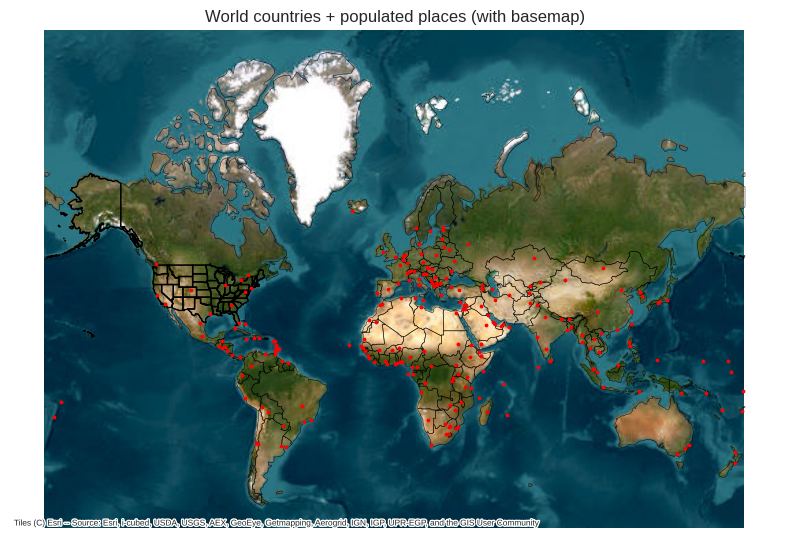

In [56]:
# Plot to understand
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Remove Antarctica
world = world[world["NAME"] != "Antarctica"]

# Use EPSG:4326 for filtering / bounds
world_4326  = world.to_crs("EPSG:4326")
places_4326 = places.to_crs("EPSG:4326")
states_4326 = states.to_crs("EPSG:4326")

# Filter places to US extent (in 4326)
minx, miny, maxx, maxy = states_4326.total_bounds
places_us_4326 = places_4326.cx[minx:maxx, miny:maxy]

# Convert to EPSG:3857 for contextily plotting
world_3857     = world_4326.to_crs("EPSG:3857")
places_3857    = places_4326.to_crs("EPSG:3857")
states_3857    = states_4326.to_crs("EPSG:3857")
places_us_3857 = places_us_4326.to_crs("EPSG:3857")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

world_3857.plot(ax=ax, color="none", edgecolor="black", linewidth=0.4, alpha=0.8)
states_3857.plot(ax=ax, color="none", edgecolor="black", linewidth=1.0)
places_3857.plot(ax=ax, markersize=3, color="red", alpha=1)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    crs=world_3857.crs,
    attribution_size=6,
)

ax.set_title("World countries + populated places (with basemap)")
ax.set_axis_off()

plt.tight_layout()
plt.show()







## Part 1 - Why spatial validity is different

The code can run and still be spatially wrong.

The next examples intentionally produce plausible but incorrect outputs.

### Example - Area calculation in geographic CRS (wrong) vs projected equal-area CRS (right)

We have previously touched on the fact that if you compute area in EPSG:4326 (degrees), values are not meaningful in square meters.

In [59]:
# Keep contiguous US only for cleaner plotting
exclude = ["02", "15", "60", "66", "69", "72", "78"]
contig = states[~states["STATEFP"].isin(exclude)].copy()
print(contig.head(1))

# Wrong: area in geographic coordinates
contig["area_bad"] = contig.area

# Better: project to CONUS Albers equal area for measurement
contig_5070 = contig.to_crs(5070)
contig["area_sqkm"] = contig_5070.area / 1_000_000

print(" ")
print(" ")
contig[["NAME", "area_bad", "area_sqkm"]].head(3)


  STATEFP   STATENS      GEOIDFQ GEOID STUSPS   NAME LSAD         ALAND  \
0      48  01779801  0400000US48    48     TX  Texas   00  676686238592   

        AWATER                                           geometry  
0  18982083586  POLYGON ((-106.62344 31.91403, -106.63011 31.9...  
 
 


/tmp/ipython-input-172357032.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contig["area_bad"] = contig.area


,NAME,area_bad,area_sqkm
0,Texas,65.778595,692662.976601
1,California,41.730153,410516.395909
2,Kentucky,10.665631,104630.073909


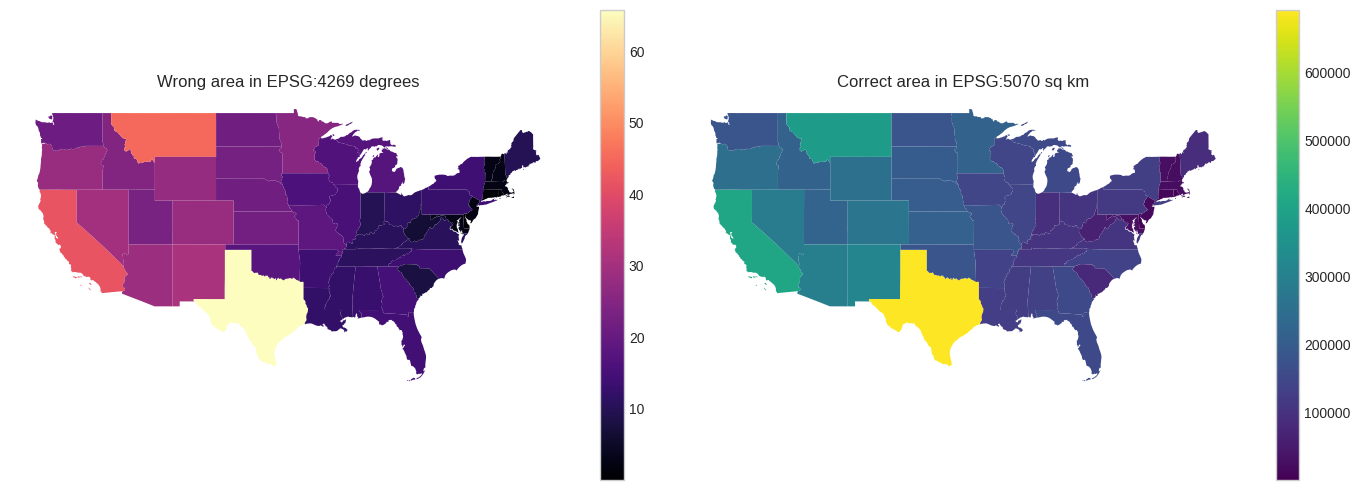

In [19]:
# Example: Plotting results as an illustration
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

contig.plot(column="area_bad", ax=ax[0], legend=True, cmap="magma")
ax[0].set_title("Wrong area in EPSG:4269 degrees")
ax[0].set_axis_off()

contig.plot(column="area_sqkm", ax=ax[1], legend=True, cmap="viridis")
ax[1].set_title("Correct area in EPSG:5070 sq km")
ax[1].set_axis_off()

plt.tight_layout()


### Exercise

- Find the 5 largest states by `sq_km` (contiguous U.S. only).
- Briefly explain why the ranking from `area_bad` is not trustworthy.

In [ ]:
# Exercise: Place your answers here



### Example B - Buffer distance in degrees (wrong) vs meters (right)

A 1-degree buffer is not a fixed distance and should not be interpreted as 1 km or 1 mile.

/tmp/ipython-input-1993400335.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bad_buf["geometry"] = bad_buf.buffer(1)


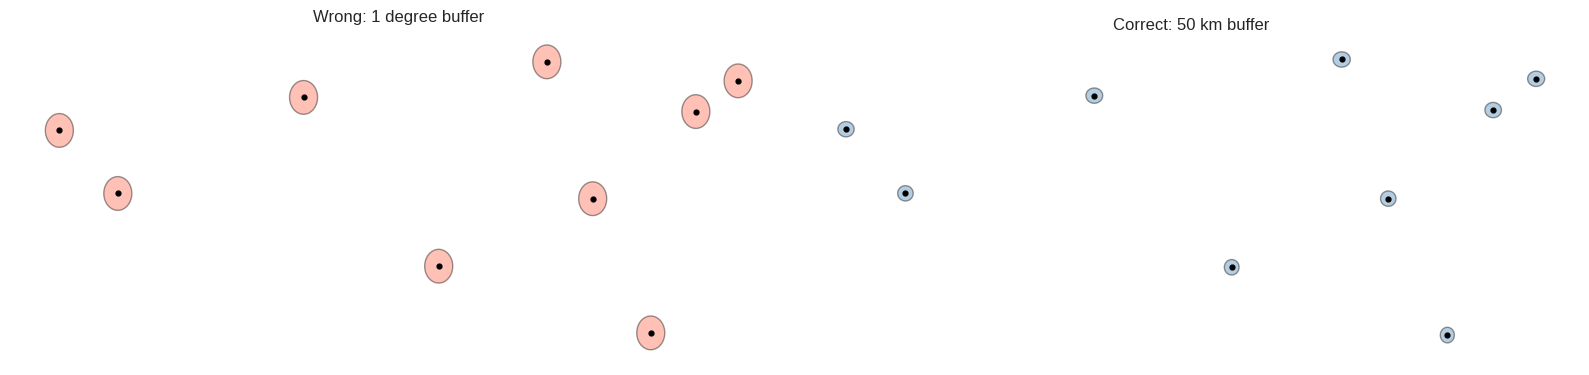

In [61]:
# Use a few US cities from Natural Earth populated places
us_places = places[places["adm0name"] == "United States of America"].copy()
us_places = us_places[["name", "geometry"]].head(10).copy()

# Wrong: buffering in geographic CRS (degrees)
bad_buf = us_places.copy()
bad_buf["geometry"] = bad_buf.buffer(1)

# Better: project to meters first, then buffer 50 km
# EPSG:5070 (NAD83 / Conus Albers). Good for contiguous United States (CONUS)
us_places_5070 = us_places.to_crs(5070)
good_buf = us_places_5070.copy()
good_buf["geometry"] = good_buf.buffer(50_000)
good_buf = good_buf.to_crs(us_places.crs)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

bad_buf.plot(ax=ax[0], color="tomato", alpha=0.4, edgecolor="black")
us_places.plot(ax=ax[0], color="black", markersize=12)
ax[0].set_title("Wrong: 1 degree buffer")

good_buf.plot(ax=ax[1], color="steelblue", alpha=0.4, edgecolor="black")
us_places.plot(ax=ax[1], color="black", markersize=12)
ax[1].set_title("Correct: 50 km buffer")

for a in ax:
    a.set_axis_off()

plt.tight_layout()


### Exercise 2

- Build a 25 km buffer around the same points.
- Plot points and buffers on a map with a good quality contextily background.
- In one sentence, state why this requires projected CRS.

In [ ]:
# Exercise: Place your answers here


### Example C - Spatial join predicate choice changes meaning

The spatial logic you use affects what counts as a match in a spatial join or spatial filter.

The same data can produce different answers depending on whether you use:

* `intersects`
* `within`
* `contains`
* or other spatial operations for intersections (e.g., `touches`)

The code may run successfully in all cases, but the result can still be conceptually wrong for your research question.

We can explore this using `within`, `contains`, and `intersects` as different spatial logic approaches.

States INTERSECTing buffer: ['New York', 'Maryland', 'Massachusetts', 'Rhode Island', 'Connecticut', 'Delaware', 'New Jersey', 'Pennsylvania']
States WITHIN buffer: []


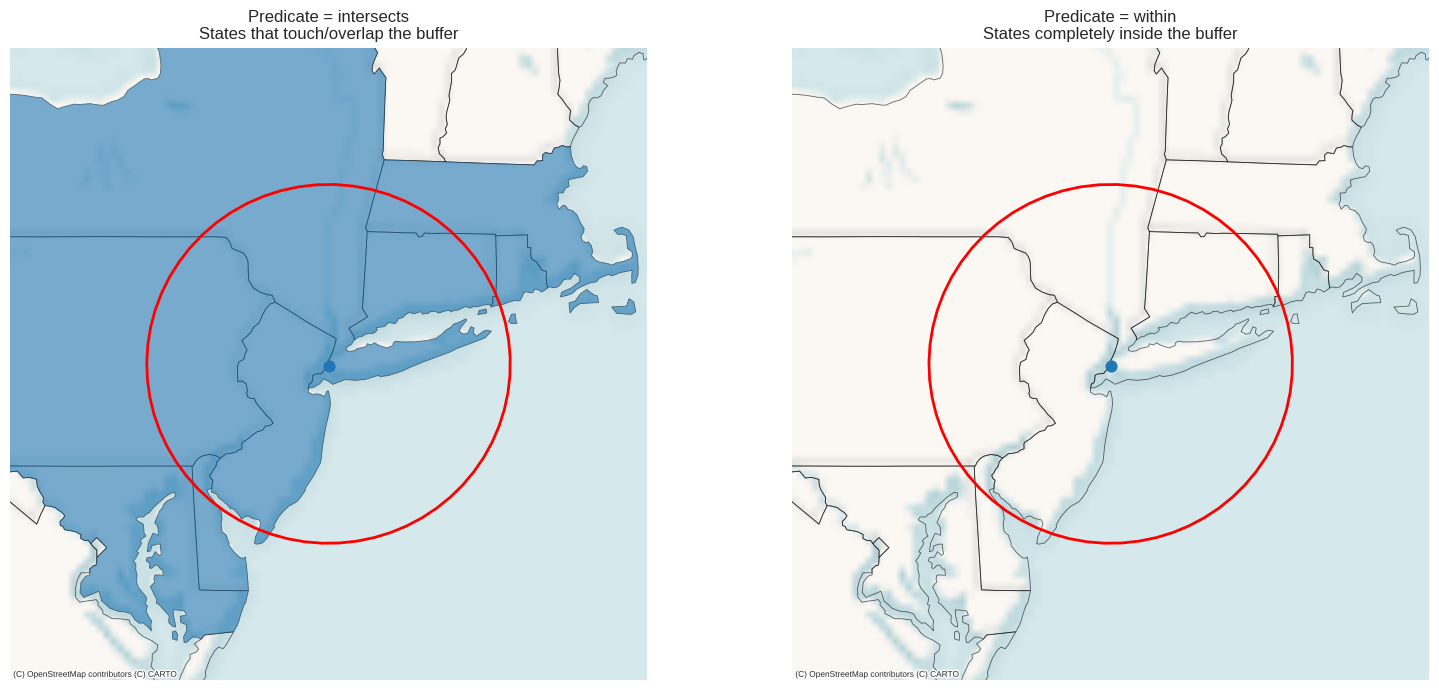

In [96]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# --- CONUS states ---
exclude_states = ["Alaska", "Hawaii", "Puerto Rico"]
state_polys = states[["NAME", "geometry"]].copy()
state_polys = state_polys[~state_polys["NAME"].isin(exclude_states)].copy()

# --- Pick ONE city point (any one is fine; NYC is common in Natural Earth) ---
us_places = places[places["adm0name"] == "United States of America"][["name", "geometry"]].copy()

# Try NYC; if not present, fall back to the first US place
if (us_places["name"] == "New York").any():
    city = us_places[us_places["name"] == "New York"].iloc[[0]]
else:
    city = us_places.iloc[[0]]

# --- Work in a projected CRS for buffering (meters) ---
states_5070 = state_polys.to_crs(epsg=5070)
city_5070 = city.to_crs(epsg=5070)

# Buffer radius in meters (try 200km)
buffer_km = 200
buffer_poly_5070 = city_5070.copy()
buffer_poly_5070["geometry"] = buffer_poly_5070.geometry.buffer(buffer_km * 1000)
buffer_poly_5070["label"] = f"{buffer_km} km buffer around {city.iloc[0]['name']}"

# --- Predicates on polygons ---
# Intersects: states that touch/overlap the buffer
states_intersects = states_5070[states_5070.intersects(buffer_poly_5070.geometry.iloc[0])].copy()
# Within: states completely inside the buffer (usually none)
states_within = states_5070[states_5070.within(buffer_poly_5070.geometry.iloc[0])].copy()

print("States INTERSECTing buffer:", states_intersects["NAME"].tolist())
print("States WITHIN buffer:", states_within["NAME"].tolist())

# --- Plot with basemap (3857) ---
states_3857 = states_5070.to_crs(epsg=3857)
city_3857 = city_5070.to_crs(epsg=3857)
buffer_3857 = buffer_poly_5070.to_crs(epsg=3857)
intersects_3857 = states_intersects.to_crs(epsg=3857)
within_3857 = states_within.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Panel A: INTERSECTS
states_3857.plot(ax=ax[0], facecolor="none", edgecolor="black", linewidth=0.6, alpha=0.6)
intersects_3857.plot(ax=ax[0], alpha=0.6)  # default color is fine
buffer_3857.plot(ax=ax[0], facecolor="none", edgecolor="red", linewidth=2)
city_3857.plot(ax=ax[0], markersize=60)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs=states_3857.crs, attribution_size=6)
ax[0].set_title("Predicate = intersects\nStates that touch/overlap the buffer")
ax[0].set_axis_off()

# Panel B: WITHIN
states_3857.plot(ax=ax[1], facecolor="none", edgecolor="black", linewidth=0.6, alpha=0.6)
if len(within_3857) > 0:
    within_3857.plot(ax=ax[1], alpha=0.7)
buffer_3857.plot(ax=ax[1], facecolor="none", edgecolor="red", linewidth=2)
city_3857.plot(ax=ax[1], markersize=60)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs=states_3857.crs, attribution_size=6)
ax[1].set_title("Predicate = within\nStates completely inside the buffer")
ax[1].set_axis_off()

# Zoom both panels to the buffer extent
minx, miny, maxx, maxy = buffer_3857.total_bounds
pad = 200_000  # meters
for a in ax:
    a.set_xlim(minx - pad, maxx + pad)
    a.set_ylim(miny - pad, maxy + pad)

plt.tight_layout()
plt.show()


Now we can do the same with a boolean selection (intersects) vs proportional overlap (overlay + percent).

By boolean, we mean true or false, 1 or 0, etc.

Top overlaps (pct of state inside buffer):
            NAME  pct_of_state_in_buffer
5       Delaware                1.000000
3   Rhode Island                1.000000
7     New Jersey                1.000000
4    Connecticut                1.000000
2  Massachusetts                0.782029
8   Pennsylvania                0.437160
1       Maryland                0.435998
0       New York                0.423114


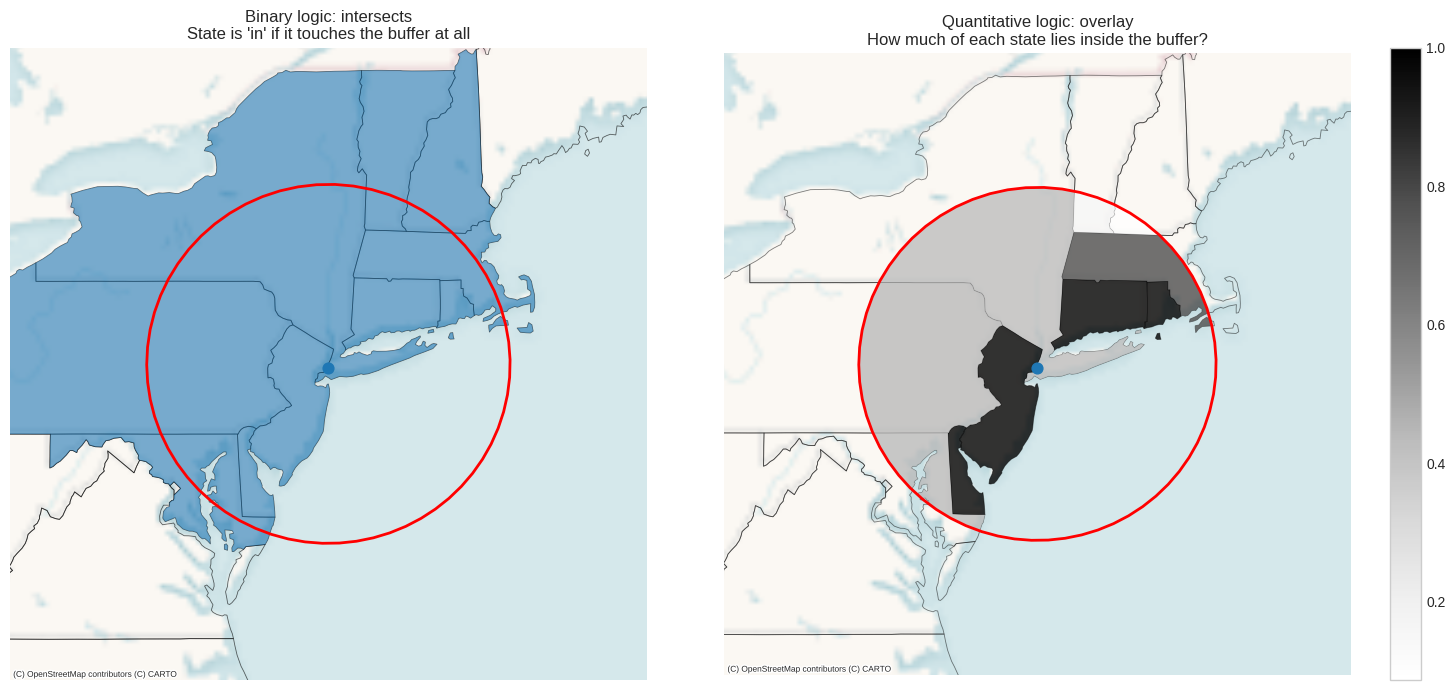

In [103]:
# Example of intersects versus overlay
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx


# Download datasets
url_ne_places = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip"
url_tiger_states = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"

places = gpd.read_file(url_ne_places)
states = gpd.read_file(url_tiger_states)

# Prep CONUS + pick a city
exclude_states = ["Alaska", "Hawaii", "Puerto Rico"]
state_polys = states[["NAME", "geometry"]].copy()
state_polys = state_polys[~state_polys["NAME"].isin(exclude_states)].copy()

us_places = places[places["adm0name"] == "United States of America"][["name", "geometry"]].copy()

target_city = "New York"
if (us_places["name"] == target_city).any():
    city = us_places[us_places["name"] == target_city].iloc[[0]]
else:
    city = us_places.iloc[[0]]

# Work in meters for area computations
states_5070 = state_polys.to_crs(epsg=5070)
city_5070 = city.to_crs(epsg=5070)

buffer_km = 300
buffer_gdf = city_5070.copy()
buffer_gdf["geometry"] = buffer_gdf.geometry.buffer(buffer_km * 1000)
buf = buffer_gdf.geometry.iloc[0]

# Boolean selection
states_intersects = states_5070[states_5070.intersects(buf)].copy()

# Proportional overlap via overlay
# Compute each state's total area once
states_5070["state_area"] = states_5070.area

# Intersect states with buffer -> intersection polygons with correct areas
intersections = gpd.overlay(
    states_5070[["NAME", "geometry", "state_area"]],
    buffer_gdf[["geometry"]],
    how="intersection"
)
intersections["overlap_area"] = intersections.area
intersections["pct_of_state_in_buffer"] = intersections["overlap_area"] / intersections["state_area"]

# Keep the top overlaps for labeling/clarity
top = intersections.sort_values("pct_of_state_in_buffer", ascending=False).head(8).copy()
print("Top overlaps (pct of state inside buffer):")
print(top[["NAME", "pct_of_state_in_buffer"]])

# Plot with basemap (EPSG:3857)
states_3857 = states_5070.to_crs(epsg=3857)
city_3857 = city_5070.to_crs(epsg=3857)
buffer_3857 = buffer_gdf.to_crs(epsg=3857)
intersects_3857 = states_intersects.to_crs(epsg=3857)
intersections_3857 = intersections.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Left: boolean intersects (binary)
states_3857.plot(ax=ax[0], facecolor="none", edgecolor="black", linewidth=0.6, alpha=0.6)
intersects_3857.plot(ax=ax[0], alpha=0.6)
buffer_3857.plot(ax=ax[0], facecolor="none", edgecolor="red", linewidth=2)
city_3857.plot(ax=ax[0], markersize=60)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs=states_3857.crs, attribution_size=6)
ax[0].set_title("Binary logic: intersects\nState is 'in' if it touches the buffer at all")
ax[0].set_axis_off()

# Right: proportional overlap (overlay polygons) – choropleth by percent overlap
states_3857.plot(ax=ax[1], facecolor="none", edgecolor="black", linewidth=0.6, alpha=0.5)
intersections_3857.plot(
    ax=ax[1],
    column="pct_of_state_in_buffer",
    legend=True,
    alpha=0.8
)
buffer_3857.plot(ax=ax[1], facecolor="none", edgecolor="red", linewidth=2)
city_3857.plot(ax=ax[1], markersize=60)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs=states_3857.crs, attribution_size=6)
ax[1].set_title("Quantitative logic: overlay\nHow much of each state lies inside the buffer?")
ax[1].set_axis_off()

# Zoom to buffer extent
minx, miny, maxx, maxy = buffer_3857.total_bounds
pad = 300_000
for a in ax:
    a.set_xlim(minx - pad, maxx + pad)
    a.set_ylim(miny - pad, maxy + pad)

plt.tight_layout()
plt.show()

### 5-10 minute exercise 3

- Compare `within` vs `intersects` counts by state and map.
- Propose which approach is more defensible for region-in-state assignment and why (e.g., for the DMV).

In [ ]:
# Exercise: Place your answers here



## Part 2 - Spatial invariants for validity checks

Spatial invariants are conditions that should hold if outputs are valid.

For example, they should be true both before and after a spatial operation.

This matters because most spatial errors do not produce crashes, for example:

* Wrong CRS - still runs
* Wrong predicate - still runs
* Overlay slivers - still runs
* Misaligned rasters - still runs


### Invariant checklist

1. CRS appropriate for operation
2. Geometries valid and non-empty
3. Join match rates plausible
4. Measurements positive and within reasonable range
5. Intermediate maps do not show obvious artifacts

In [105]:
# Example: Create a function to validate spatial results
# Then run a quick validation example

def validate_spatial_results(left_gdf, right_gdf, join_result=None, measurement_crs=None):
    """Minimal reusable validation helper for class exercises."""

    report = {}

    report["left_crs"] = str(left_gdf.crs)
    report["right_crs"] = str(right_gdf.crs)
    report["crs_match"] = left_gdf.crs == right_gdf.crs

    report["left_invalid_geoms"] = int((~left_gdf.is_valid).sum())
    report["right_invalid_geoms"] = int((~right_gdf.is_valid).sum())
    report["left_empty_geoms"] = int(left_gdf.is_empty.sum())
    report["right_empty_geoms"] = int(right_gdf.is_empty.sum())

    if measurement_crs is None:
        report["measurement_crs_provided"] = False
    else:
        report["measurement_crs_provided"] = True
        report["measurement_crs"] = measurement_crs

    if join_result is not None and "NAME" in join_result.columns:
        report["join_rows"] = int(len(join_result))
        report["join_unmatched_rows"] = int(join_result["NAME"].isna().sum())
        report["join_match_rate"] = float(1 - (join_result["NAME"].isna().mean()))

    return pd.Series(report)

# Run a quick validation example
example_join = gpd.sjoin(us_places, state_polys, how="left", predicate="within")
validate_spatial_results(us_places, state_polys, join_result=example_join, measurement_crs=5070)

/tmp/ipython-input-3884682459.py:32: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  example_join = gpd.sjoin(us_places, state_polys, how="left", predicate="within")


,0
left_crs,EPSG:4326
right_crs,EPSG:4269
crs_match,False
left_invalid_geoms,0
right_invalid_geoms,0
left_empty_geoms,0
right_empty_geoms,0
measurement_crs_provided,True
measurement_crs,5070
join_rows,9


### Exercise

- Extend `validate_spatial_results` with one extra check of your choice.
- Examples: Check duplicate IDs, impossible density values, area <= 0 count.
- Apply it to one of today's outputs (e.g., the spatial join examples).

In [ ]:
# Exercise: Place your answers here


## Part 3 - Broken workflow debugging lab

This workflow is intentionally flawed. Your job is to identify issues and produce a corrected output.

Goal: Count populated places per US state and compute place density (places per 10,000 sq km).

The broken version below includes multiple spatial validity problems.

In [111]:
# Example: BROKEN WORKFLOW (intentional mistakes)

# 1) No US filter: includes all global places
lab_places = places.copy()

# 2) CRS mismatch during spatial join
lab_states_bad = states.to_crs(3857)
joined_bad = gpd.sjoin(lab_places, lab_states_bad[["NAME", "geometry"]], how="left", predicate="contains")

# 3) Area computed in wrong CRS
states["area_sqkm_bad"] = states.area / 1_000_000

# 4) Density from invalid numerator + invalid denominator
bad_counts = joined_bad.groupby("NAME").size().reset_index(name="place_count_bad")
lab_out_bad = states.merge(bad_counts, on="NAME", how="left")
lab_out_bad["place_count_bad"] = lab_out_bad["place_count_bad"].fillna(0)
lab_out_bad["density_bad"] = lab_out_bad["place_count_bad"] / (lab_out_bad["area_sqkm_bad"] / 10_000)

lab_out_bad[["NAME", "place_count_bad", "area_sqkm_bad", "density_bad"]].head()


/tmp/ipython-input-2276076099.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  joined_bad = gpd.sjoin(lab_places, lab_states_bad[["NAME", "geometry"]], how="left", predicate="contains")
/tmp/ipython-input-2276076099.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states["area_sqkm_bad"] = states.area / 1_000_000


,NAME,place_count_bad,area_sqkm_bad,density_bad
0,Texas,0.0,0.000066,0.0
1,California,0.0,0.000042,0.0
2,Kentucky,0.0,0.000011,0.0
3,Georgia,0.0,0.000015,0.0
4,Wisconsin,0.0,0.000017,0.0


### Exercise

Find and fix at least five issues.

Expected fixes include:

- Filter to US populated places before join
- Use CRS alignment before overlay/join
- Use defensible predicate (`within` or `intersects`, justified)
- Compute area in an equal-area CRS
- Recompute density with corrected values
- Report validation metrics (match rate, null joins, etc.)

In [ ]:
# Exercise: Place your answers here


### Exercise

- Add one additional plausibility check to the corrected output.
- Example checks:
  - no negative density
  - density below a chosen threshold
  - contiguous US vs non-contiguous comparison
- Briefly justify your threshold/logic.

In [ ]:
# Exercise: Place your answers here


## Part 4 - Discussion

Discuss as a class:

- Why can't spatial validation be fully automated?
- Which checks can an AI assistant run reliably?
- Where is human geographic judgment required?
- What risks happen when we automate before validating spatial meaning?